In [14]:
# Import Python libraries
import os
import warnings
import time
import joblib
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

In [15]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
set_config(display='diagram')

In [16]:
data = pd.read_csv('StackOverflow_cleaned.csv',sep=";", index_col=0,converters={"Title": literal_eval,
                                                                                 "Body": literal_eval,
                                                                                  "Tags": literal_eval})

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24044 entries, 0 to 27048
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   24044 non-null  object
 1   Body    24044 non-null  object
 2   Score   24044 non-null  int64 
 3   Tags    24044 non-null  object
dtypes: int64(1), object(3)
memory usage: 939.2+ KB


In [18]:
data=data[0:5000]

In [19]:
data

,Title,Body,Score,Tags
0,"[core, dump, linux, segmentation, fault]","[process, linux, segmentation, fault, core, dump]",237,"[linux, bash]"
1,"[php, server, mysql, server, time, zone]","[hosting, package, godaddy, network, solution,...",12,"[php, mysql]"
2,"[constraint, landscape, orientation]","[constraint, device, example, image, portrait,...",48,"[ios, cocoa-touch]"
3,"[loading, system, servicemodel, configuration,...","[net, wcf, wcf, configuration, client, applica...",64,"[c#, .net]"
4,"[xml, serialization, inherited, type]","[question, object, model, xml, problem, quelle...",86,[c#]
...,...,...,...,...
5562,"[difference, listview, datagrid, wpf]","[question, database, user, screen, control, co...",55,"[.net, wpf]"
5563,"[header, guard]","[learncppcom, look, preprocessor, header, guar...",38,"[c++, c]"
5564,"[whisker, definition, geom_boxplot]","[geom_boxplot, boxplot, whisker, percentile, i...",33,[r]
5565,"[problem, uiswipegesturerecognizer, uislider]","[gesture, problem, uiswipegesturerecognizer, s...",26,[iphone]


LDA :


In [20]:
X = data["Body"]
y = data["Tags"]
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [21]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('core', 1),
  ('dump', 1),
  ('fault', 1),
  ('linux', 1),
  ('process', 1),
  ('segmentation', 1)]]

In [22]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [23]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('core', 1),
  ('dump', 1),
  ('fault', 1),
  ('linux', 1),
  ('process', 1),
  ('segmentation', 1)]]

In [24]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


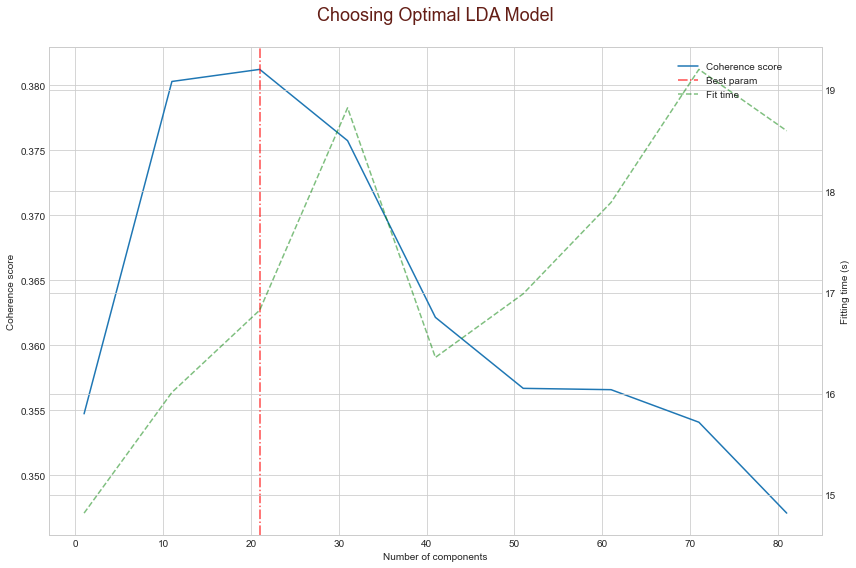

In [25]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [27]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
                                  
gensimvis.prepare(best_lda_model, corpus, id2word)

C:\Users\Aeorn\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.006543 -0.011034       1        1  6.990117
10    -0.001715 -0.008361       2        1  6.693496
12     0.015470 -0.000769       3        1  5.984353
0      0.002907 -0.013127       4        1  5.834929
17    -0.000143 -0.012403       5        1  5.832322
6     -0.065922 -0.013693       6        1  5.610627
5     -0.007318  0.008311       7        1  5.455094
2     -0.021391  0.000410       8        1  5.002016
11     0.045282  0.016293       9        1  4.960151
7     -0.044338 -0.001351      10        1  4.920629
19    -0.001063  0.019547      11        1  4.813945
18    -0.028674 -0.022113      12        1  4.760189
8      0.005913 -0.008320      13        1  4.667942
3     -0.002248 -0.014062      14        1  4.620218
13     0.037876  0.020310      15        1  4.310017
14    -0.020567 -0.019726      16        1  4.176317
16    -0.015948

In [29]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model.get_document_topics(corpus,minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])


# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)


print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (5000, 50)
document/topic :  (5000, 21)


In [30]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.006805,0.006805,0.006805,0.863903,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805,...,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805,0.006805
1,0.002802,0.002802,0.002802,0.002802,0.303557,0.643211,0.002802,0.002802,0.002802,0.002802,...,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802,0.002802
2,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,...,0.312534,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175


In [31]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(21, 50)

In [32]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,30.507410,3.280557,4.424321,4.248546,3.662340,3.823938,0.871397,1.965211,15.938986,44.099720,...,1.917515,4.489325,15.577352,8.833893,0.570336,1.325140,3.014645,6.162531,8.553192,2.768167
1,34.439001,0.923666,11.052774,9.353689,4.104517,5.830567,1.068815,5.402286,19.828716,59.245188,...,5.194377,6.639504,7.928618,4.019734,16.062679,1.409379,0.444304,9.090727,18.417452,2.499296
2,32.416461,3.809120,8.298032,7.181788,7.467337,5.639484,0.789445,23.262797,30.224880,47.405564,...,15.529263,1.111783,3.079240,3.610593,4.487827,0.508191,5.291788,15.544528,4.181024,5.834731
3,26.496346,1.698135,8.982685,11.468565,1.011268,8.905812,9.733588,11.196613,11.144939,34.983636,...,9.189250,0.424014,6.013927,0.927778,1.604624,2.565242,1.963487,10.138942,4.120640,3.140554
4,15.719887,1.587680,4.689247,18.712700,2.495776,4.508727,1.718104,1.537855,4.953205,22.634240,...,2.995312,0.151787,4.339655,3.748903,2.303636,5.925470,0.416163,1.321626,10.913494,3.415223
5,23.620597,4.035178,8.057445,19.392268,15.043026,10.811710,6.418681,1.428343,12.023362,40.320012,...,5.863578,5.563510,2.949656,4.392873,3.168397,5.067486,10.566621,3.343729,1.961173,4.728338
6,24.000949,9.073701,1.703850,13.250954,1.679610,19.726776,5.271035,1.959754,8.844902,36.317593,...,1.588048,4.088179,2.494584,4.796700,1.508986,5.024852,8.508497,4.946730,2.094168,7.619847
7,26.704671,4.505494,11.302273,10.250969,9.585489,5.919676,3.419793,2.104387,6.893615,33.260366,...,1.196025,3.801565,7.517324,7.885668,4.394057,0.751021,7.201740,7.389831,7.092260,1.218317
8,14.229364,2.685544,11.441583,9.056942,2.635469,3.259923,1.337650,1.782198,10.922326,23.710942,...,1.554220,0.821861,2.494764,1.551397,2.836563,1.854754,5.839307,2.495549,0.472128,2.609146
9,19.698719,2.150665,3.679307,7.556159,2.571305,6.008308,1.776021,4.832535,5.520202,33.675991,...,3.973653,1.957551,4.480401,3.039556,1.924619,0.992939,1.900268,9.700905,3.927491,1.970898


In [33]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_bin.groupby(df_y_bin.index)))

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
0,"[linux, bash]",3,2,"[7, 25]"
1,"[php, mysql]",5,2,"[28, 34]"
2,"[ios, cocoa-touch]",10,2,"[12, 19]"


In [35]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic].sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
0,"[linux, bash]",3,2,"[7, 25]","[9, 0]"
1,"[php, mysql]",5,2,"[28, 34]","[21, 9]"
2,"[ios, cocoa-touch]",10,2,"[12, 19]","[19, 20]"


In [36]:
def metrics_score(model, df, y_true, y_pred):
 
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [37]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [38]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

C:\Users\Aeorn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Accuracy,0.077000
F1,0.252919
Jaccard,0.072157
Recall,0.189812
Precision,0.138201
